# <a id='toc1_'></a>[__Метод опорных векторов__](#toc0_)

**Содержание**<a id='toc0_'></a>    
- [__Метод опорных векторов__](#toc1_)    
  - [__Импорты и настройки__](#toc1_1_)    
  - [__Геометрическая интуиция и начальные соображения__](#toc1_2_)    
  - [__Гиперплоскость и классификация с ее помощью__](#toc1_3_)    
  - [__SVMTutorial__](#toc1_4_)    
  - [__Линейно разделимая выборка__](#toc1_5_)    
  - [__Линейно неразделимая выборка__](#toc1_6_)    
  - [__Влияние гиперпараметра $C$ на положение разделяющей гиперплоскости__](#toc1_7_)    
  - [__Cats & Dogs__](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Импорты и настройки__](#toc0_)

In [1]:
# стандартная библиотека
from pathlib import Path

In [2]:
# сторонние библиотеки
from IPython.display import Image
from scipy.stats import multivariate_normal
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# глобальные настройки графических библиотек
params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(palette='tab10', style='ticks', rc=params)
matplotlib.rcParams['figure.dpi'] = 400

***
## <a id='toc1_2_'></a>[__Геометрическая интуиция и начальные соображения__](#toc0_)

Будет рассматриваться только двухклассовая классификация.

Геометрические соображения ведут к основной идее SVM в случае линейно разделимой выборки – __построению разделяющей гиперплоскости, отстающей на максимальные, но равные расстояния от ближайших к ней тренировочных представителей классов__:

* Элементы разных классов должны находиться как можно дальше от разделяющей прямой (гиперплоскости). В этом случае, с точки зрения логики и здравого смысла, классы различимы "лучше всего".

* Расстояние от разделяющей прямой до ближайшего представителя как одного, так и другого класса должно быть одинаковым: прямая должна проходить "посередине" между классами.

* Разделяющая полоса должна иметь наибольшую ширину.

***
## <a id='toc1_3_'></a>[__Гиперплоскость и классификация с ее помощью__](#toc0_)

В $p$-мерном пространстве __гиперплоскостью__ $l$ называется множество точек, координаты которых удовлетворяют уравнению вида

$$l: \quad \theta_0 + \theta_1 X_1 + \theta_2 X_2 + \dots + \theta_p X_p = 0,$$

в котором $\theta_1^2 + \theta_2^2 + \dots + \theta_p^2 \ne 0$ (хотя бы один из коэффициентов отличен от нуля).

Пусть дана гиперплоскость $l$, задаваемая уравнением

$$l: \quad \theta_0 + \theta_1 X_1 + \theta_2 X_2 + \dots + \theta_p X_p = 0.$$

Тогда вектор $n = (\theta_1, \theta_2, \dots ,\theta_p)$ называется __нормалью__ гиперплоскости $l$.

Рассмотрим функцию

$$f(X) = f(X_1,X_2,\dots,X_p) = \theta_0 + \theta_1 X_1 + \theta_2 X_2 + \dots + \theta_p X_p.$$

Если точка $X$ лежит на гиперплоскости, то, согласно определению последней, $f(X) = 0$. Если точка $X$ не лежит на гиперплоскости, то либо $f(X) > 0$, что означает, что точка лежит по одну сторону от гиперплоскости (то есть попадает в один класс, который мы будем в дальнейшем обозначать $+1$), либо $f(X) < 0$, что означает, что точка лежит по другую сторону от гиперплоскости (и попадает в другой класс, $-1$).

Знак выражения $f(X)$ при одном и том же $X$ зависит от направления нормали. __Условимся называть положительным классом точки той части пространства после разделения, в сторону которой направлена нормаль__.

Чем больше для тестового объекта $z$ значение $|f(z)|$, тем дальше объект расположен от разделяющей гиперплоскости и тем увереннее классификация, т.е. тем меньше шанс ошибиться и присвоить объекту неправильный класс.

In [4]:
data = np.array([[0.5, 4, 1], [1, 0, 1], [1, 2, 1], [2, 1, 1],
                 [2.5, 5, -1], [3, 7, -1], [3.5, 3, -1], 
                 [4, 1, -1], [4, 6, -1], [5, 4, -1]])

headers = 'X1', 'X2', 'Response'

df = pd.DataFrame(data, columns=headers, index=range(1, data.shape[0]+1))
df

,X1,X2,Response
1,0.5,4.0,1.0
2,1.0,0.0,1.0
3,1.0,2.0,1.0
4,2.0,1.0,1.0
5,2.5,5.0,-1.0
6,3.0,7.0,-1.0
7,3.5,3.0,-1.0
8,4.0,1.0,-1.0
9,4.0,6.0,-1.0
10,5.0,4.0,-1.0


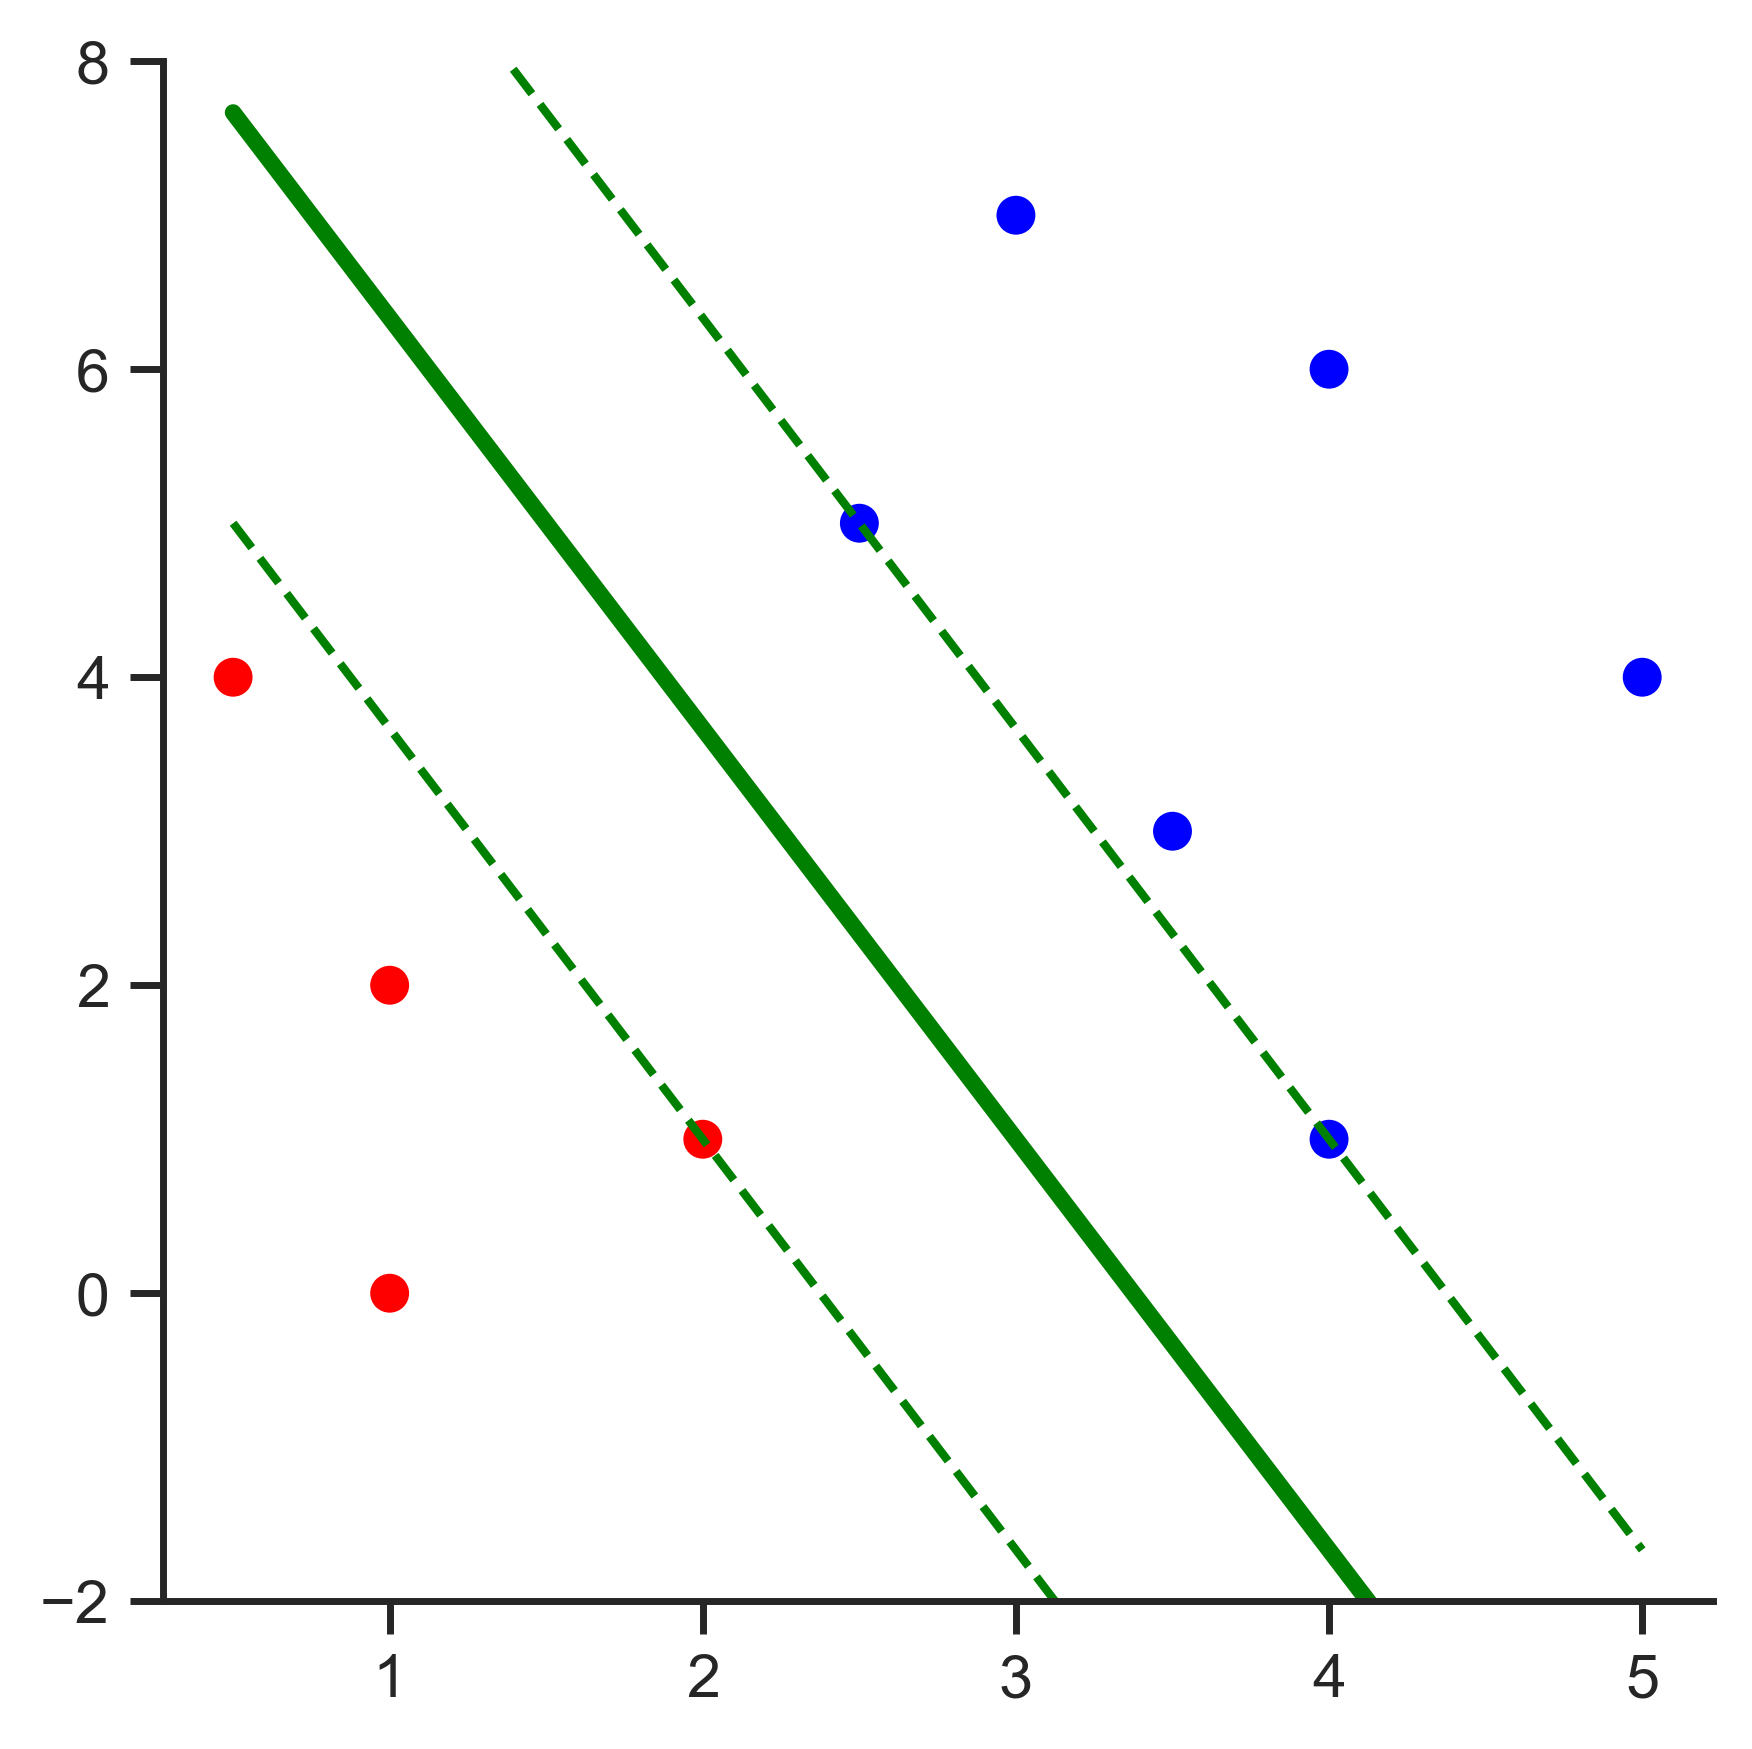

In [5]:
colors = df.Response.map({1: 'r', -1: 'b'})
x = np.linspace(0.5, 5, 5)

plt.figure(figsize=(5,5))
plt.scatter(df.X1, df.X2, c=colors)
plt.plot(x, -8/3*x + 9, '-g', lw=3)
plt.plot(x, -8/3*x + 19/3, '--g')
plt.plot(x, -8/3*x + 35/3, '--g')
plt.ylim(-2,8)
plt.show()

***
## <a id='toc1_4_'></a>[__SVMTutorial__](#toc0_)

[__Site__](https://svmtutorial.online/) | [__pdf__](https://svmtutorial.online/download.php?file=SVM_tutorial.pdf)

__Пояснение к Figure 1a__.

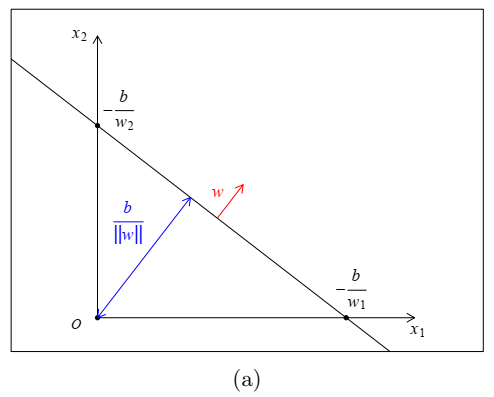

$$w_1 x_1 + w_2 x_2 + b = 0$$

Площадь прямоугольного треугольника через полупроизведение катетов и полупроизведение основания и высоты (искомого расстояния $\rho$ от $O$ до гиперплоскости):

$$\frac{b^2}{w_1 w_2} = \rho \sqrt{\frac{b^2}{w^2_1} + \frac{b^2}{w^2_2}} = \rho \sqrt{\frac{b^2 w^2_2 + b^2 w^2_1}{w^2_1 w^2_2}} = \frac{b\rho}{w_1 w_2} \sqrt{w^2_1 + w^2_2}$$

$$b = \rho \|w\|, \quad \rho = \frac{b}{\|w\|}$$

__Пояснение к Figure 3b__.

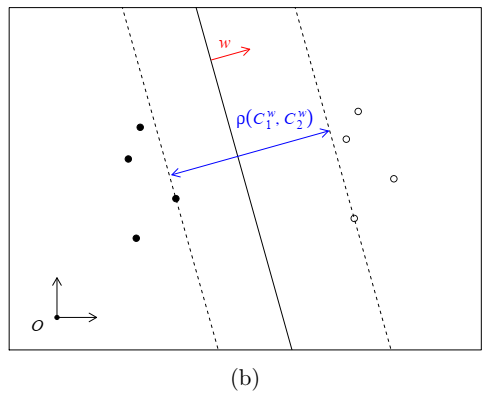

Каждая точка обоих классов проецируется на нормаль гиперплоскости. Перебираются все пары проекций-антагонистов и измеряется расстояние между ними. Минимальное такое расстояние и есть расстояние между классами.

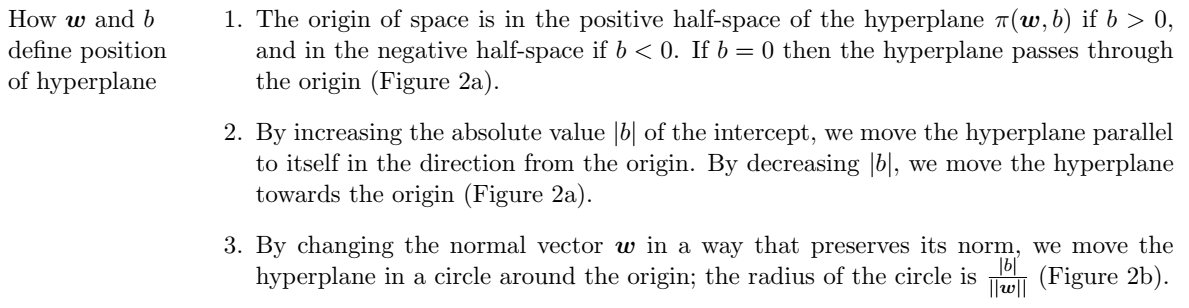

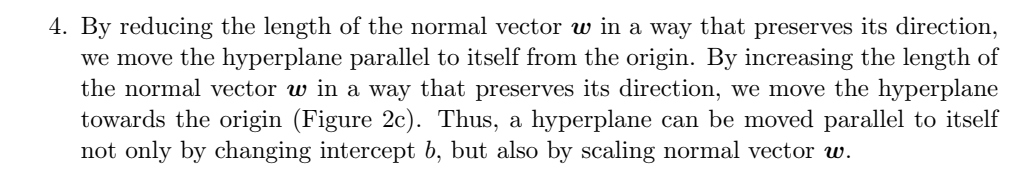

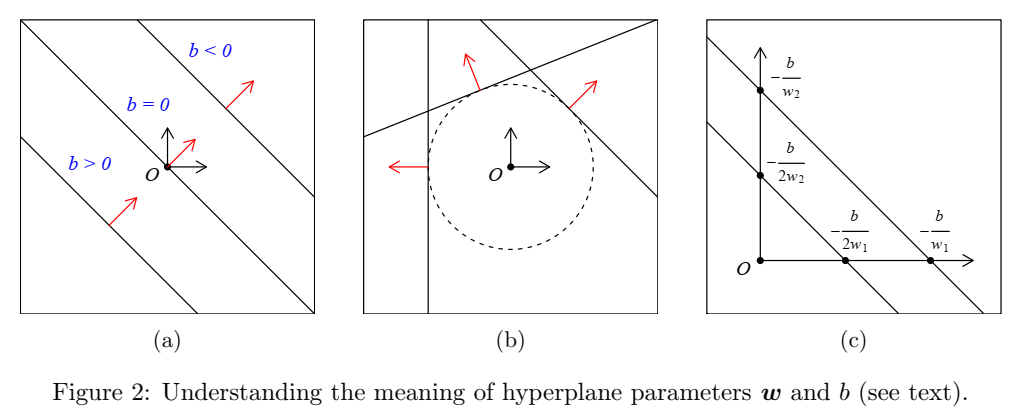

***
## <a id='toc1_5_'></a>[__Линейно разделимая выборка__](#toc0_)

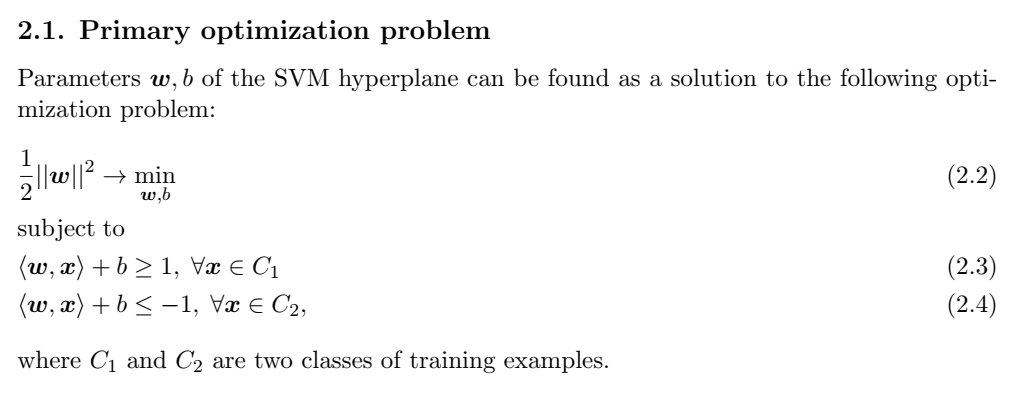

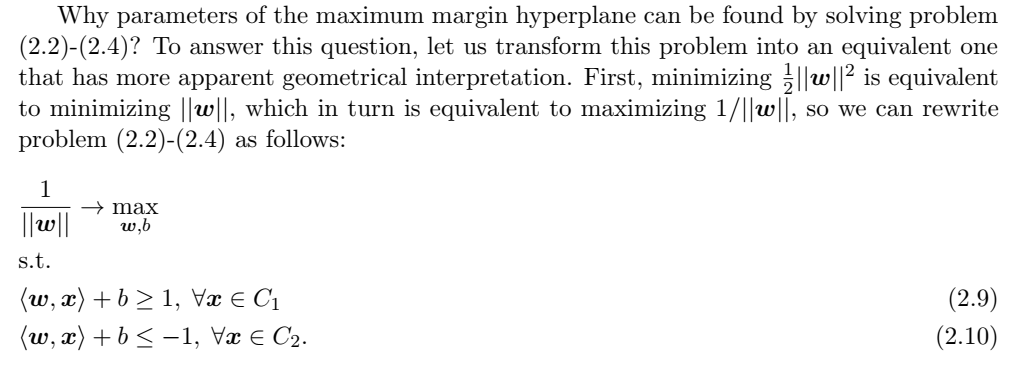

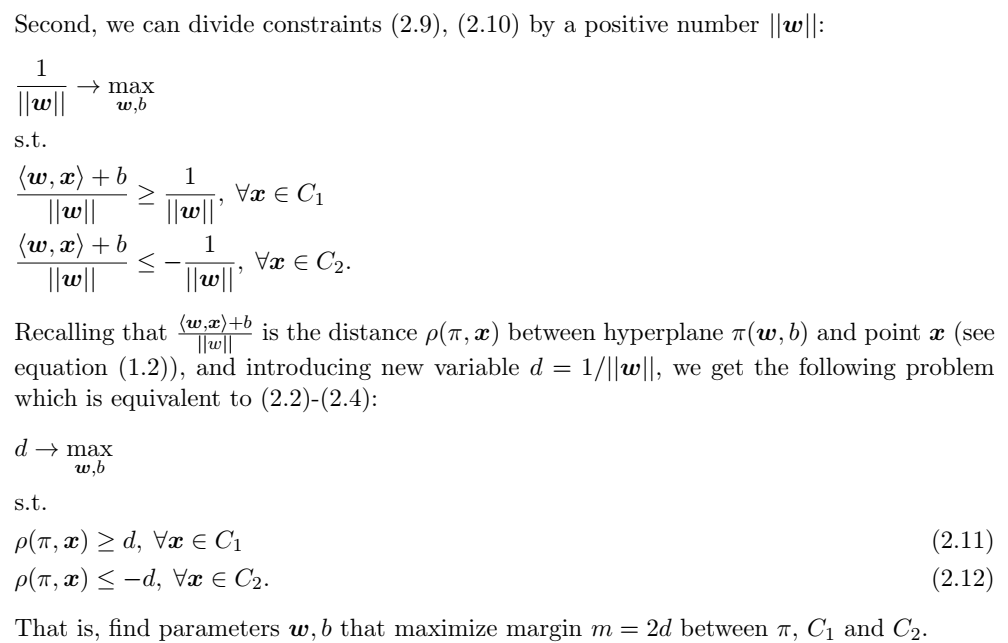

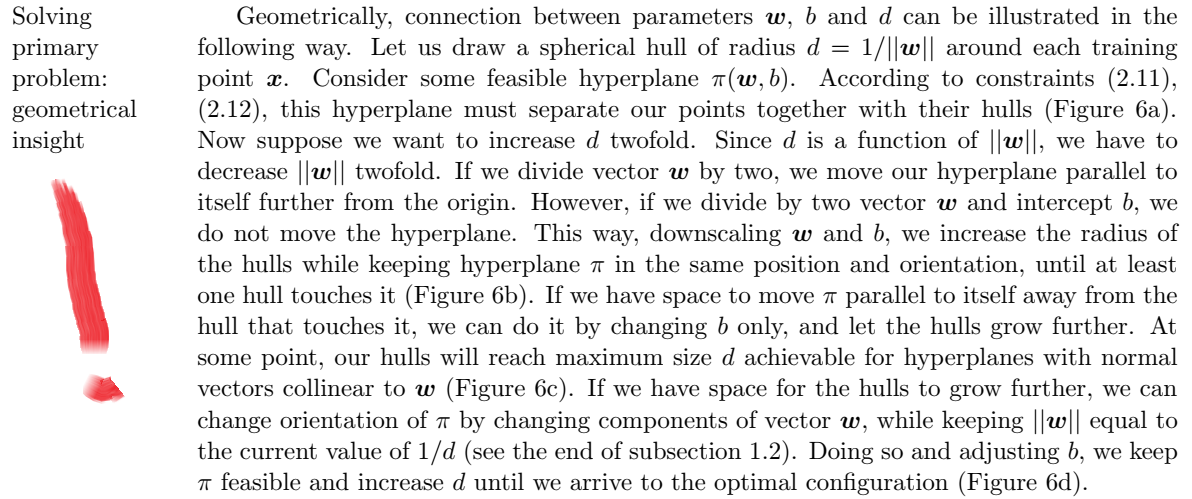

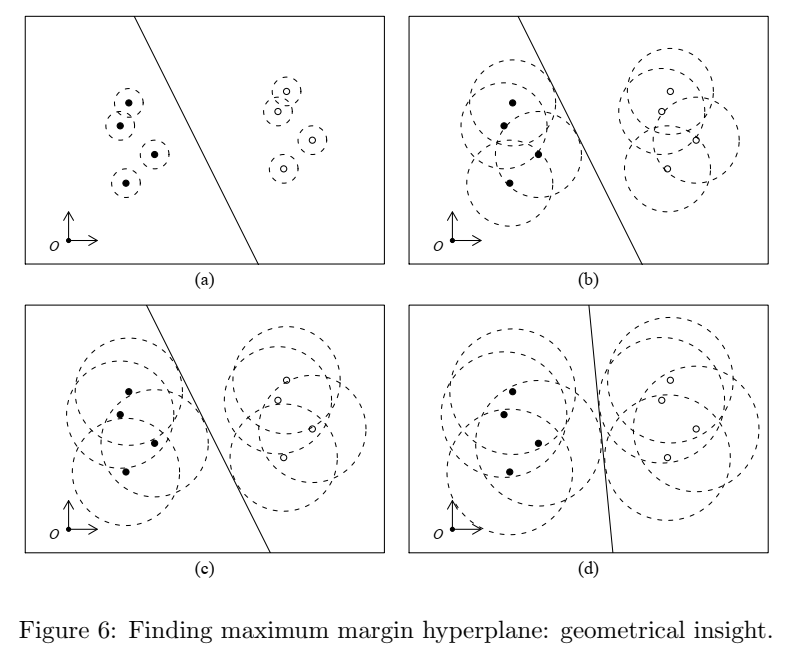

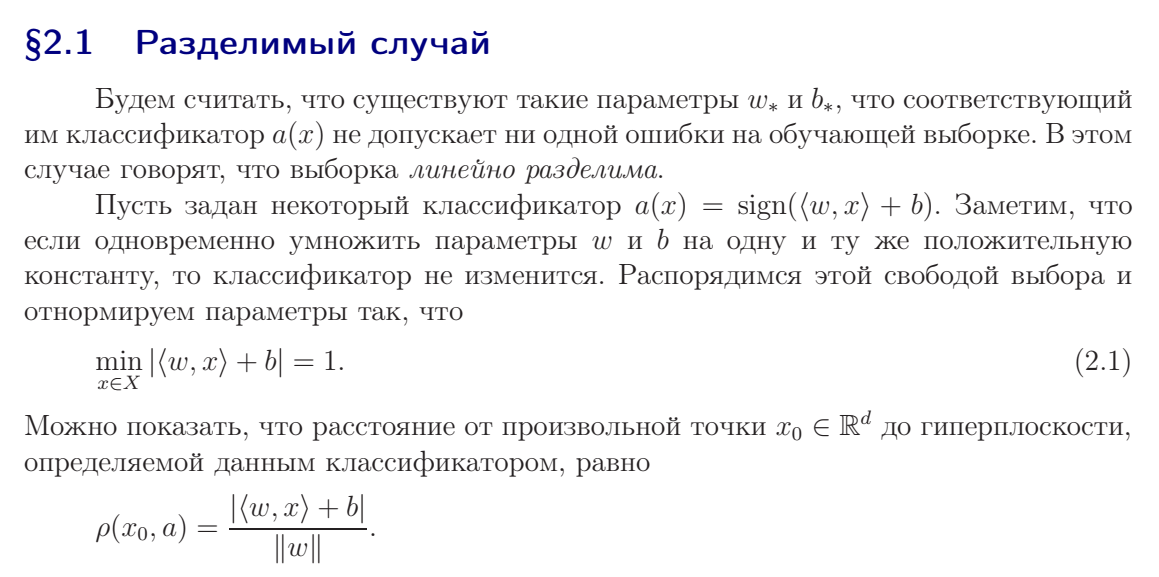

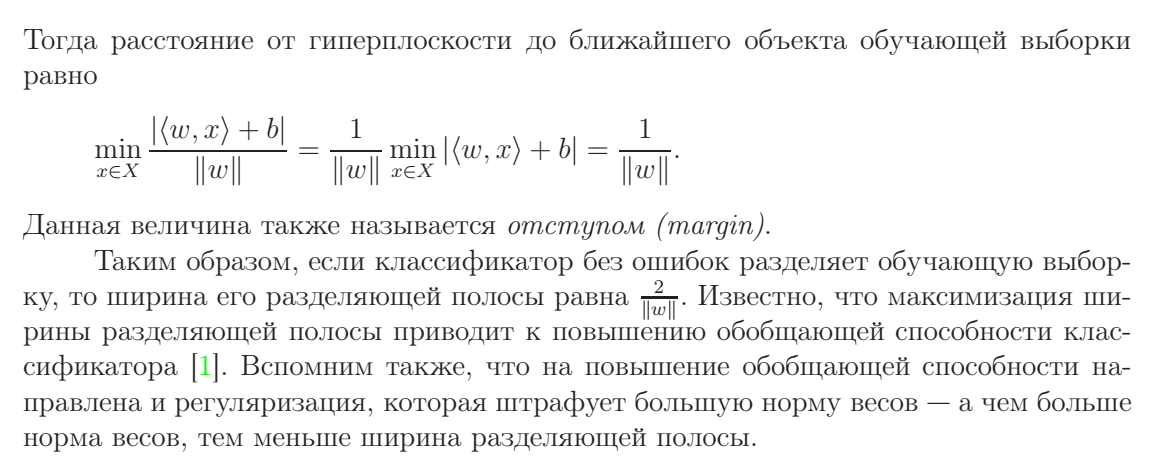

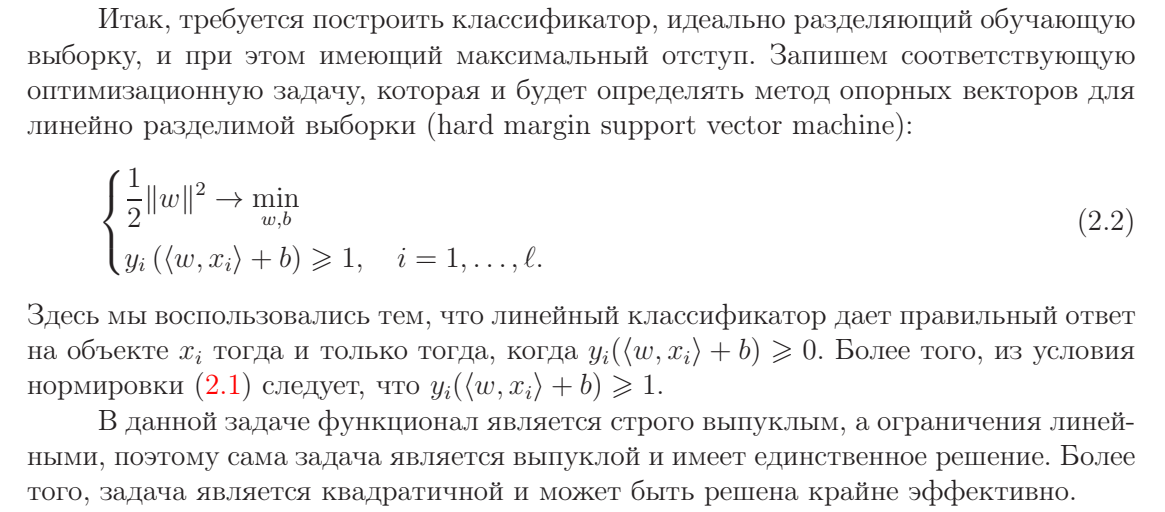

***
## <a id='toc1_6_'></a>[__Линейно неразделимая выборка__](#toc0_)

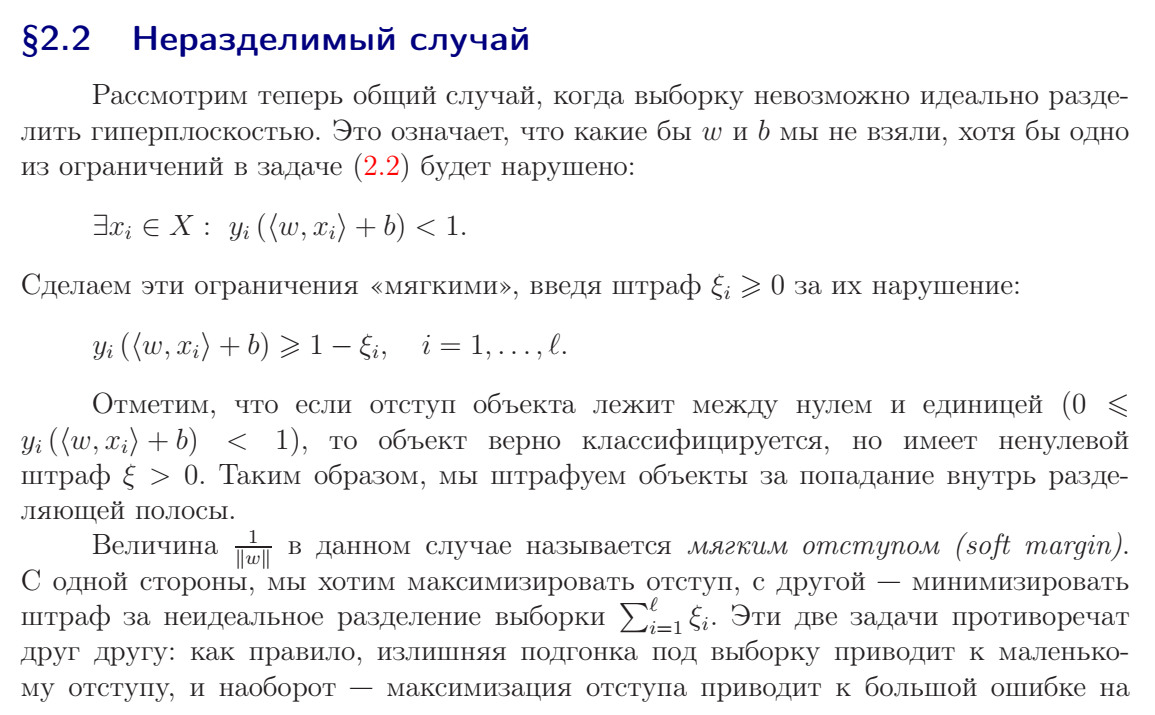

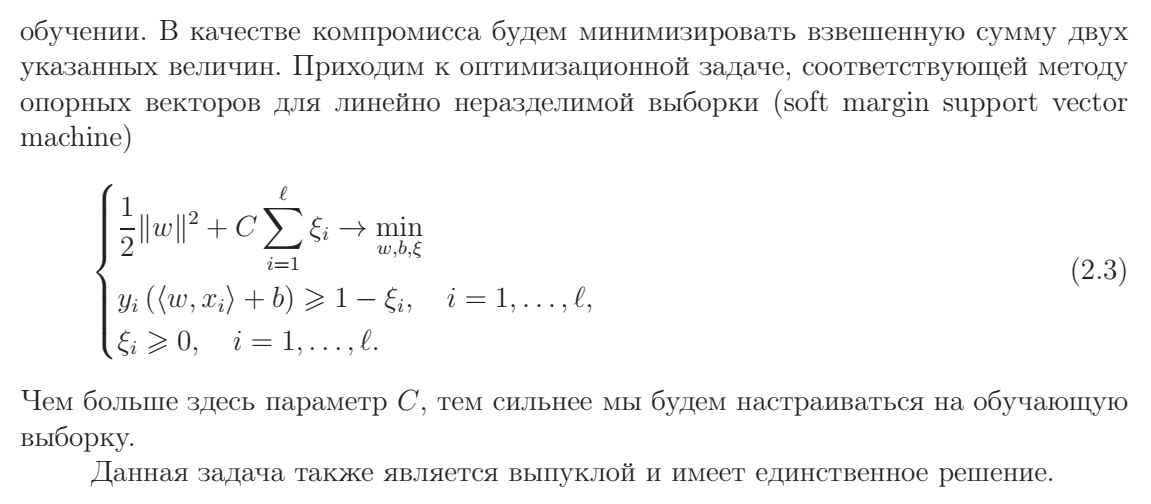

***
## <a id='toc1_7_'></a>[__Влияние гиперпараметра $C$ на положение разделяющей гиперплоскости__](#toc0_)

In [6]:
random_state = 2128506
size = 1000
means = [5, 3], [0, 0]
covs = [[4, 0], [0, 1]], [[4, 0], [0, 2]]
colors = 'blue', 'red'
planes = 'red', 'orange', 'green', 'blue', 'magenta'
x = np.linspace(-6, 15, 22)
C_values = 0.0001, 0.001, 1, 1000, 10000

samples = [multivariate_normal.rvs(mean, cov, size, random_state=random_state)
           for mean, cov in zip(means, covs)]

data = np.r_[*samples]
y = np.array([-1]*size + [1]*size)

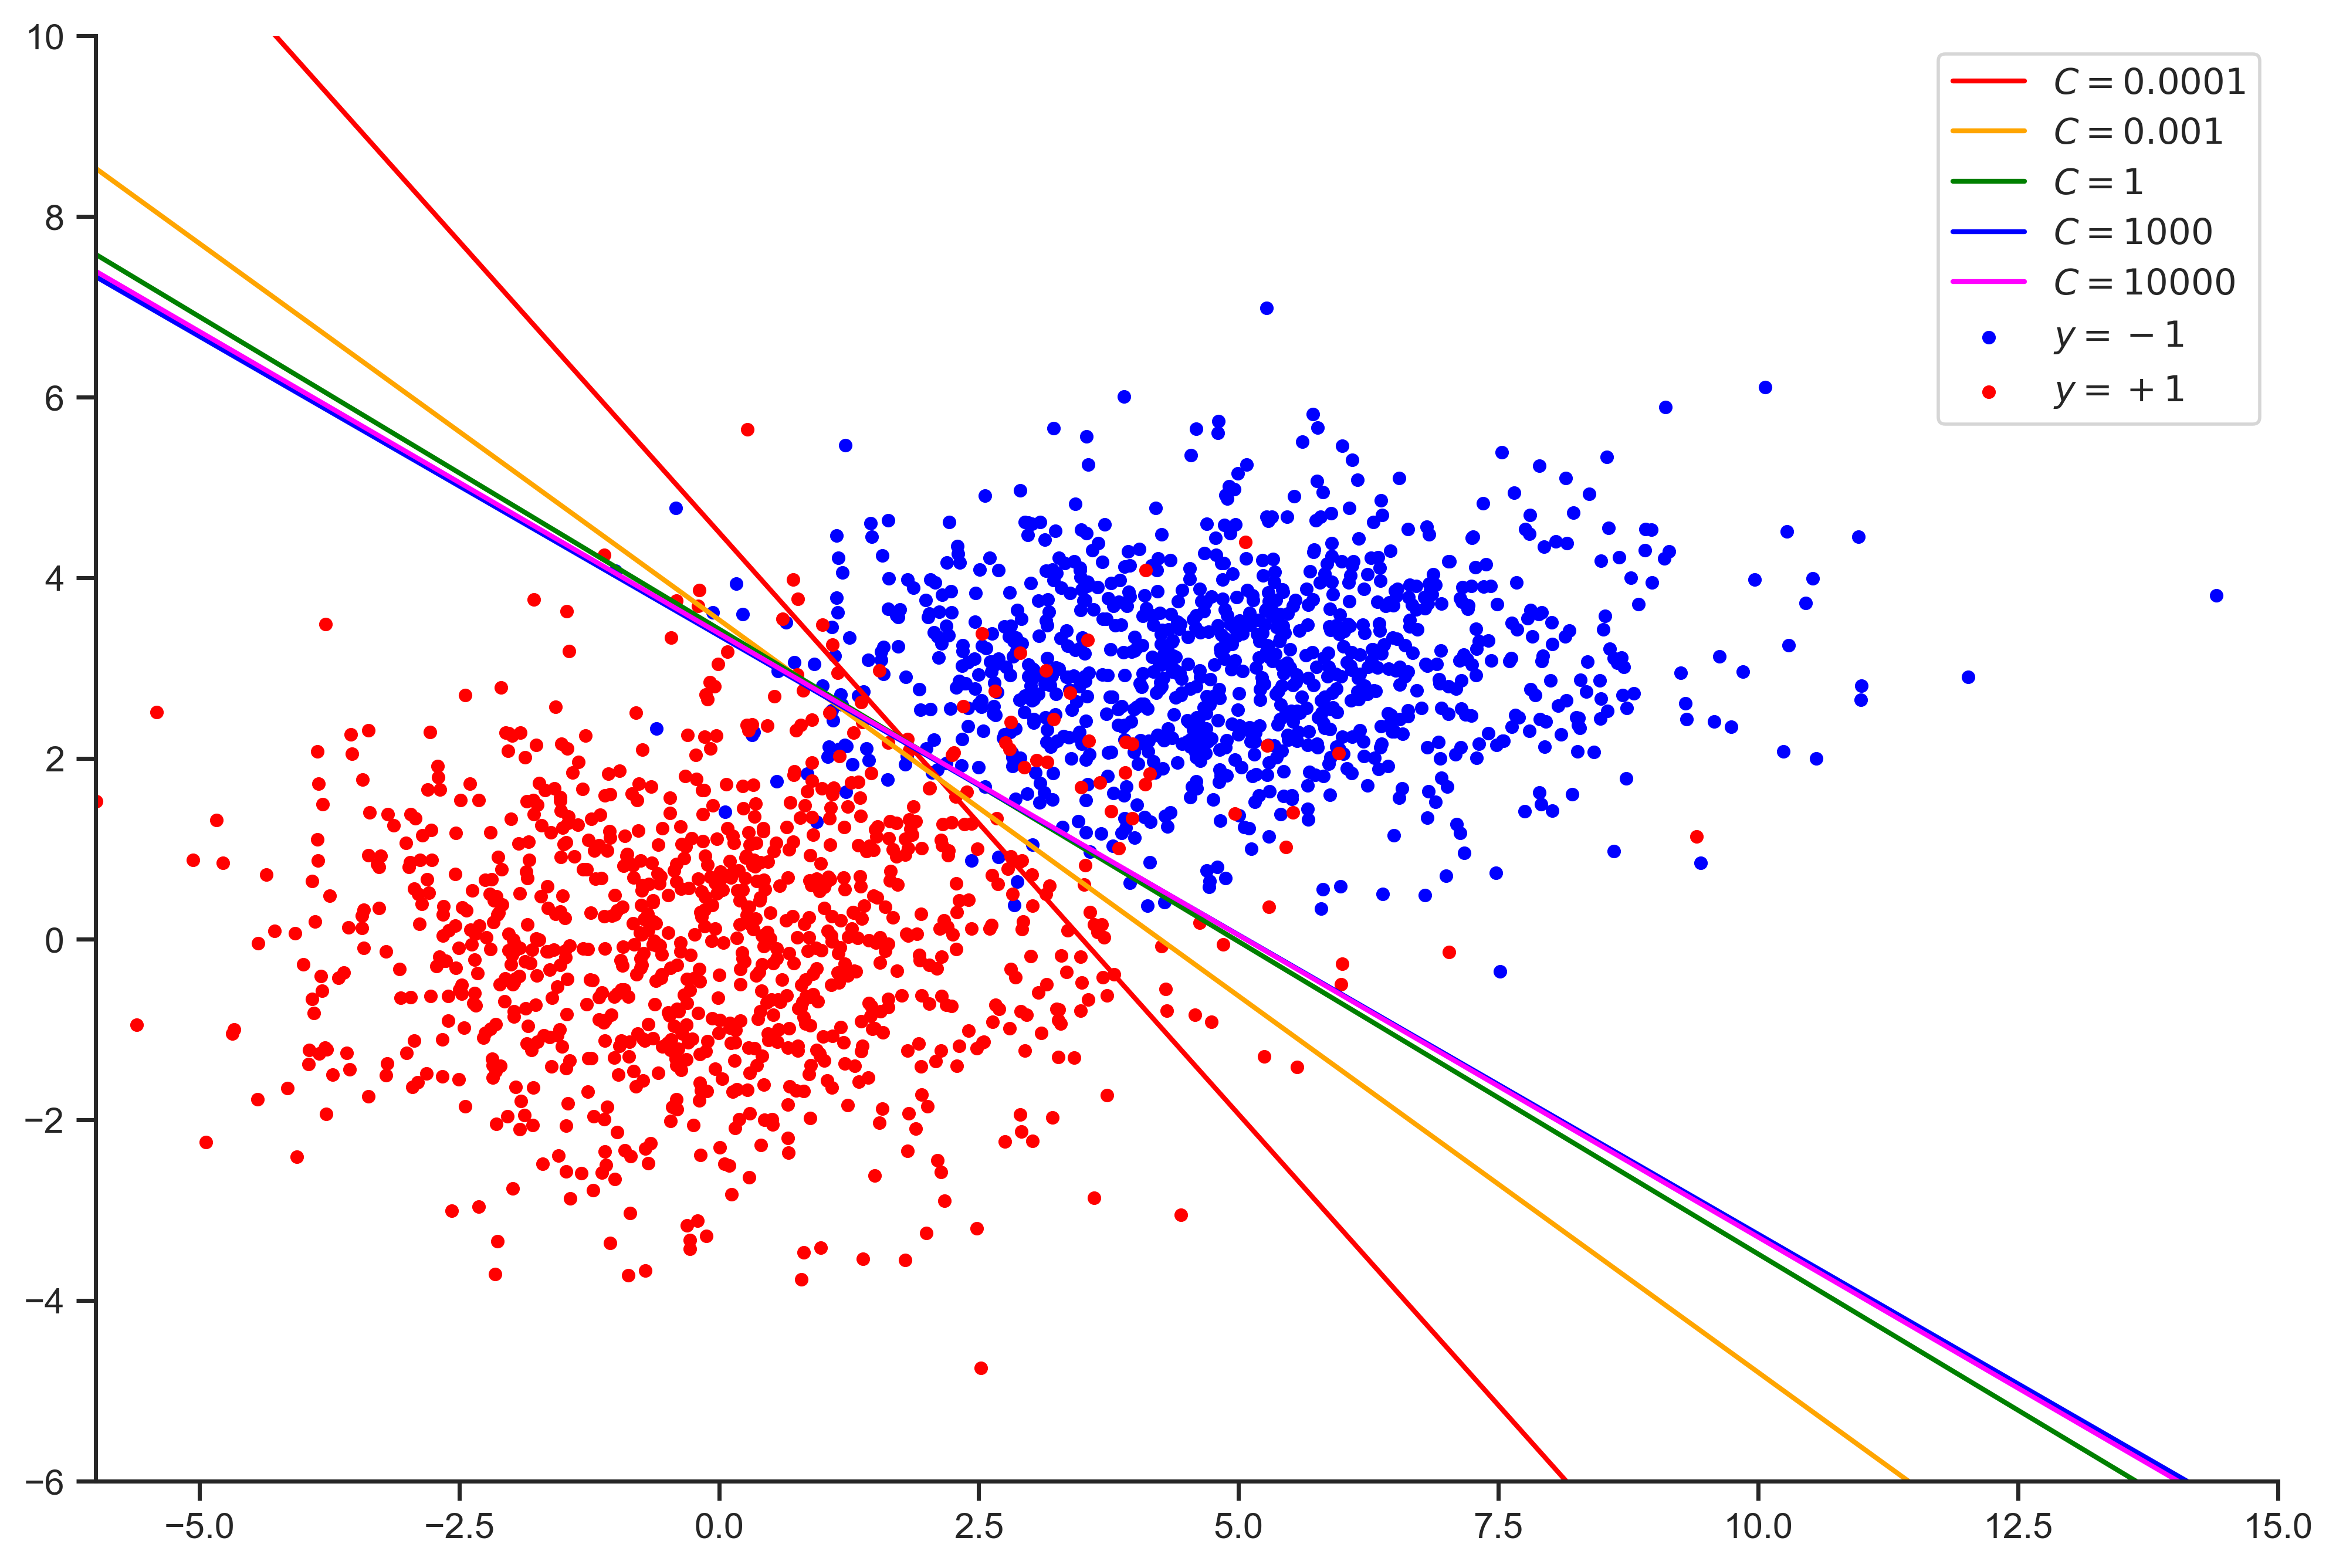

In [7]:
plt.figure(figsize=(12,8))

for C, color in zip(C_values, planes):
    svc = SVC(C=C, kernel='linear', random_state=random_state).fit(data, y)
    bias = svc.intercept_.item()
    w1, w2 = svc.coef_.squeeze()
    plt.plot(x, -(w1*x + bias) / w2, c=color, label=f'${C=}$')

for sample, color, sign in zip(samples, colors, '-+'):
    plt.scatter(*sample.T, c=color, s=10, label=f'$y={sign}1$')

plt.legend()
plt.xlim(-6,15)
plt.ylim(-6,10)
plt.show()

Гиперпараметр $C$ отвечает за то, что более приоритетно для классификатора - подгонка под обучающую выборку или максимизация ширины разделяющей полосы:
* При больших значениях $C$ классификатор сильно настраивается на обучение, тем самым сужая разделяющую полосу.
* При маленьких значениях $C$ классификатор расширяет разделяющую полосу, допуская ошибки на некоторых объектах обучающей выборки.

Если учесть положение центров, то становится очевидным, что более дотошная (т.е. более настроенная на обучение, с большим $C$) гиперплоскость будет стремиться повернуться против часовой стрелки, чтобы полнее охватить (точнее классифицировать) правое крыло красного класса и левое крыло синего.

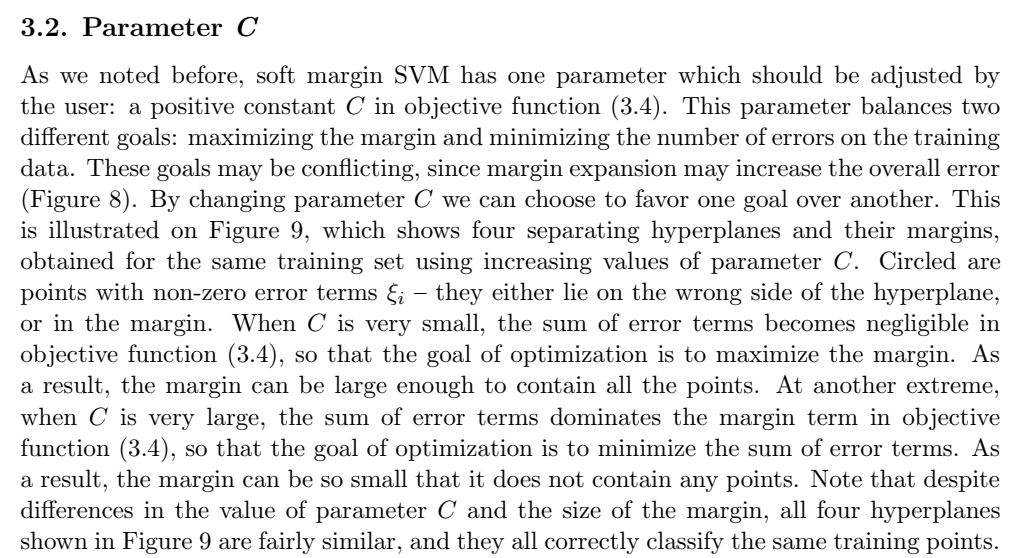

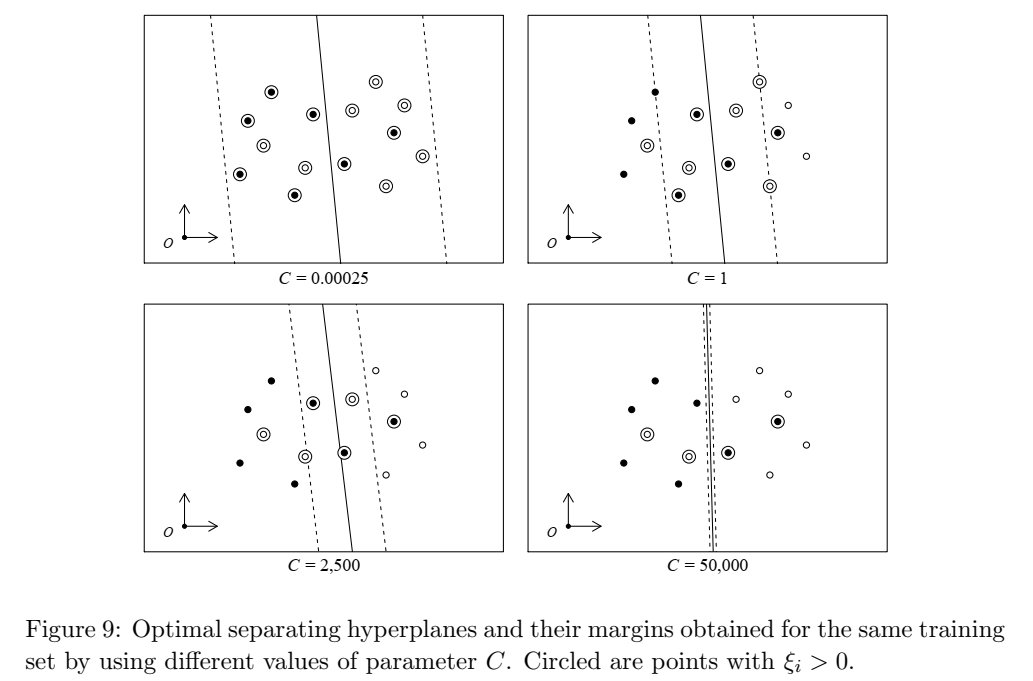

***
## <a id='toc1_8_'></a>[__Cats & Dogs__](#toc0_)

[__OpenCV: Histogram calculation__](https://docs.opencv.org/3.4/d8/dbc/tutorial_histogram_calculation.html)

$3$ канала/измерения (R, G, B) по $8$ бинов в каждом - это $8^3 = 512$ комбинаций, или $512$ признаков, означающих количество пикселей с данной комбинацией номеров бинов интенсивности цвета.

In [8]:
def extractHistogram(image):
    hist = cv2.calcHist(
        [image],  # images to process
        [0, 1, 2],  # 3 channels: R, G, B
        None,  # optional mask
        (8, 8, 8),  # histogram sizes in each dimension (num of bins)
        [0, 128, 0, 128, 0, 256]  # histogram bin boundaries in each dimension
    )
    cv2.normalize(hist, hist)
    return hist.flatten()

In [9]:
def getSubsets(relpath):
    imagePaths = [p.resolve() for p in Path(relpath).iterdir()]
    data, labels = [], []
    for imagePath in imagePaths:        
        image = cv2.imread(str(imagePath))
        hist = extractHistogram(image)
        data.append(hist)        
        label = imagePath.stem.split('.')[0]
        labels.append(label)    
    return data, labels, imagePaths

In [10]:
data, labels, imagePaths = getSubsets('cats_dogs/train')

In [11]:
lenc = LabelEncoder()
labels = lenc.fit_transform(labels)

$cat$ в папке следует перед $dog$, поэтому, разумеется, класс котов получил метку $0$, класс собак - метку $1$:

In [12]:
labels[499]

0

In [13]:
labels[500]

1

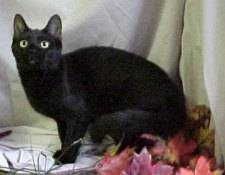

In [14]:
Image(filename=imagePaths[499])

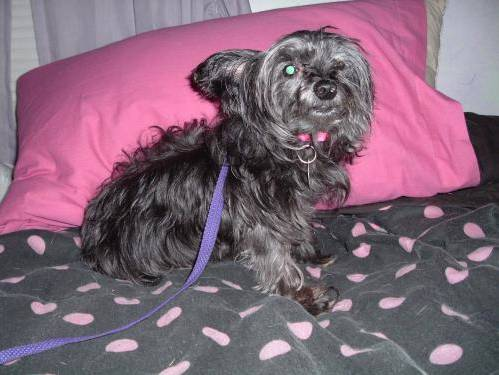

In [15]:
Image(filename=imagePaths[500])

In [16]:
trainData, valData, trainLabels, valLabels = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

In [17]:
model = LinearSVC(C=2).fit(trainData, trainLabels)
predLabels = model.predict(valData)
print(classification_report(valLabels, predLabels, target_names=lenc.classes_))

              precision    recall  f1-score   support

         cat       0.59      0.64      0.61        96
         dog       0.64      0.59      0.61       104

    accuracy                           0.61       200
   macro avg       0.61      0.61      0.61       200
weighted avg       0.61      0.61      0.61       200



c:\Users\mered\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [18]:
f1_score(valLabels, predLabels, average='macro')

0.61

In [19]:
testData, testLabels, imagePaths = getSubsets('cats_dogs/test')
testLabels = lenc.transform(testLabels)

In [20]:
testLabels[49]

0

In [21]:
testLabels[50]

1

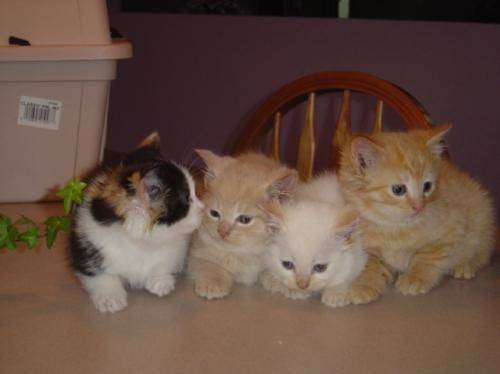

In [22]:
Image(filename=imagePaths[49])

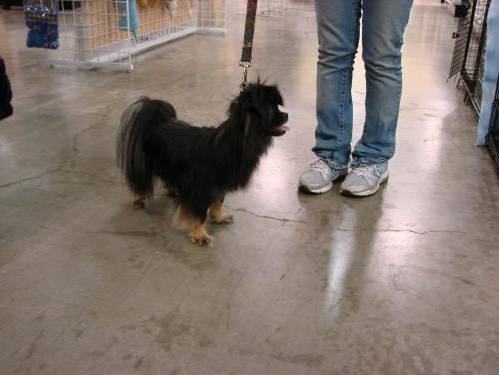

In [23]:
Image(filename=imagePaths[50])

In [24]:
predLabels = model.predict(testData)
print(classification_report(testLabels, predLabels, target_names=lenc.classes_))

              precision    recall  f1-score   support

         cat       0.63      0.82      0.71        50
         dog       0.74      0.52      0.61        50

    accuracy                           0.67       100
   macro avg       0.69      0.67      0.66       100
weighted avg       0.69      0.67      0.66       100



In [25]:
f1_score(testLabels, predLabels, average='macro')

0.6624040920716112

Ниже каждая пятая неправильная классификация. Если изображен кот (метка $0$), классификатор идентифицирует его как собаку (метка $1$) - ошибка $\text{I}$ рода. Соответственно, изображения собак - ошибки $\text{II}$ рода: эффект есть (класс в действительности положительный, $1$), хотя классификатор решил, что эффекта нет,  класс отрицательный.

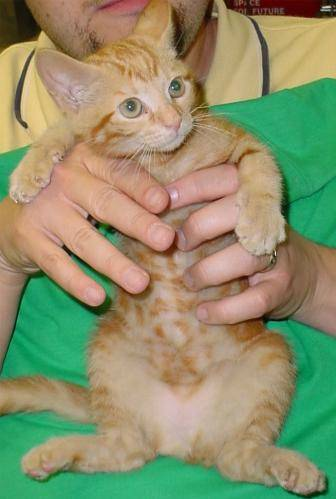

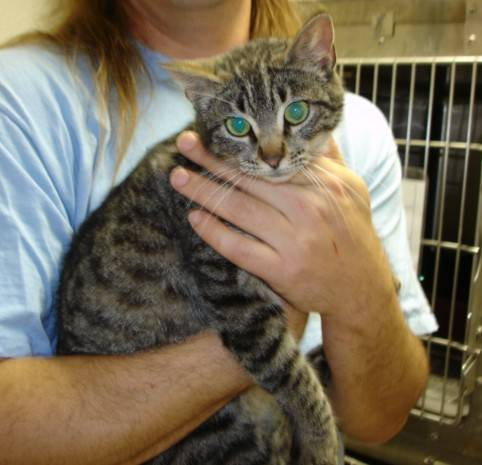

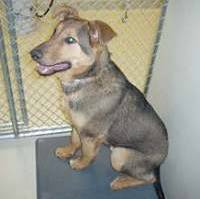

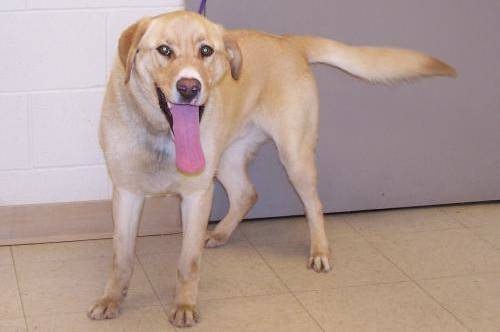

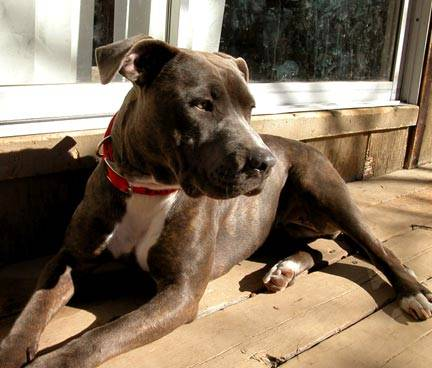

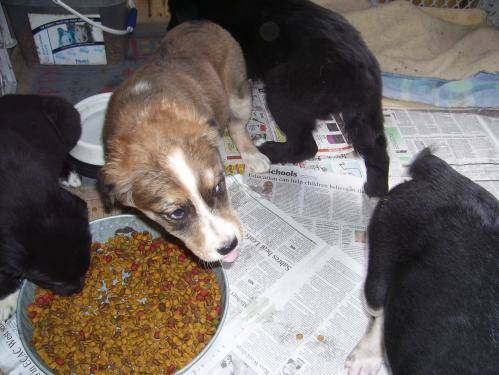

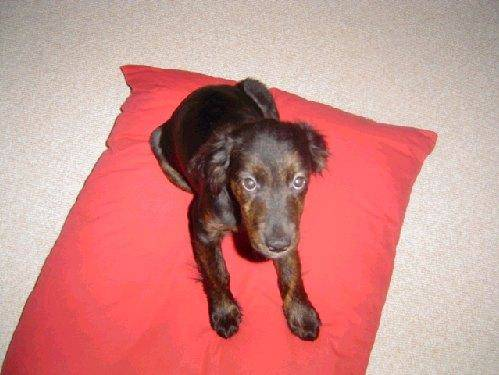

In [26]:
for wrong in np.nonzero(testLabels != predLabels)[0][::5]:
    display(Image(filename=imagePaths[wrong]))

***